# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("/kaggle/input/work-space/Udacity_AZDIAS_Subset.csv", sep=";")



In [34]:
#  print the first few rows
azdias.head()



/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [32]:
# Load in the feature summary file.

feature_summary= pd.read_csv('/kaggle/input/work-space/AZDIAS_Feature_Summary.csv', delimiter=';')

In [36]:
#  print the first few rows
feature_summary.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [37]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).


print("General Population Data Shape:", azdias.shape)
print("First few rows of General Population Data:")
azdias.head()


General Population Data Shape: (891221, 85)
First few rows of General Population Data:


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [38]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("\nCustomer Data Shape:", feature_summary.shape)
print("First few rows of Customer Data:")
feature_summary.head()


Customer Data Shape: (85, 4)
First few rows of Customer Data:


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [39]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [40]:
# Using this function to convert the strings of a list to actual lists
# Extract the column name and missing value codes
missing_value_dict = {}
for _, row in feature_summary.iterrows():
    try:
        missing_values = eval(row['missing_or_unknown'])  # Convert string list to actual list
        if isinstance(missing_values, list):
            missing_value_dict[row['attribute']] = missing_values
    except:
        pass  # Skip if conversion fails (e.g., missing or improperly formatted values)

# Replace missing value codes with NaN
for col, missing_values in missing_value_dict.items():
    if col in azdias.columns:
        azdias[col] = azdias[col].replace(missing_values, np.nan)

# Check missing values after conversion
print("\nMissing values in General Population Data (after conversion):")
print(azdias.isnull().sum())


Missing values in General Population Data (after conversion):
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUS

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [41]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Calculate percentage of missing values for each column
missing_values = azdias.isnull().mean() * 100 

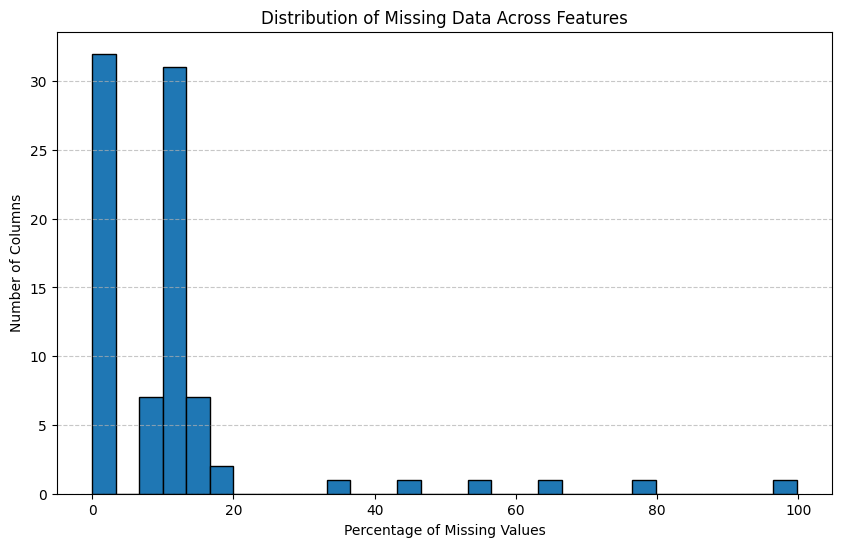

In [42]:
# Investigate patterns in the amount of missing data in each column.
# Plot histogram of missing values
plt.figure(figsize=(10, 6))
plt.hist(missing_values, bins=30, edgecolor='black')
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Number of Columns")
plt.title("Distribution of Missing Data Across Features")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [43]:

# Identify columns with high missing values (e.g., above 30%)
threshold = 30  
high_missing_cols = missing_values[missing_values > threshold].index.tolist()

In [44]:
print(f"\nColumns with more than {threshold}% missing values ({len(high_missing_cols)} columns):")
print(high_missing_cols)


Columns with more than 30% missing values (6 columns):
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [46]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(columns=high_missing_cols, inplace=True)


In [47]:
# Save the cleaned datasets to CSV
azdias.to_csv("azdias_cleaned.csv", index=False)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [3]:
# Load the cleaned dataset back if needed
azdias_cleaned = pd.read_csv("/kaggle/input/work-space/azdias_cleaned.csv")


In [3]:
# How much data is missing in each row of the dataset?
azdias_cleaned["missing_count"] = azdias_cleaned.isnull().sum(axis=1)


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


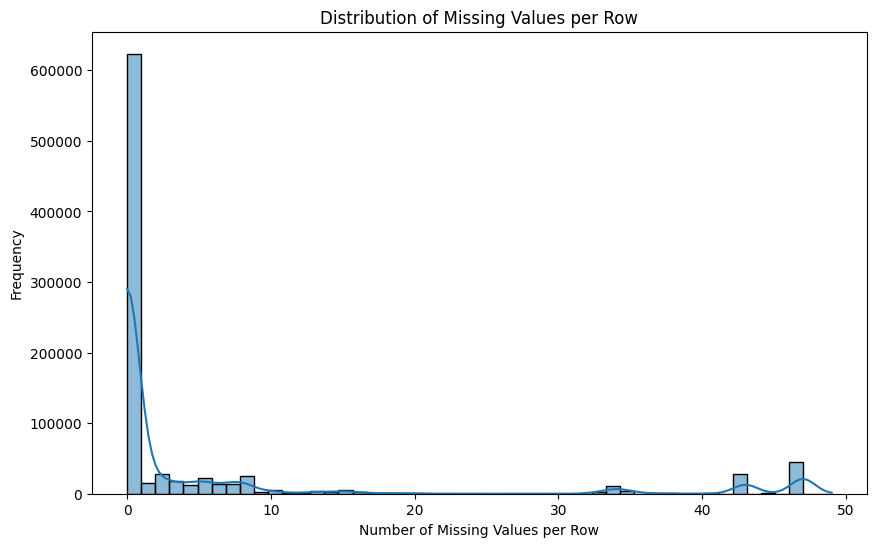

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(azdias_cleaned["missing_count"], bins=50, kde=True)
plt.xlabel("Number of Missing Values per Row")
plt.ylabel("Frequency")
plt.title("Distribution of Missing Values per Row")
plt.show()

In [5]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Define a threshold for high missing values (e.g., 30% of the data missing)
threshold = 0.3 * azdias_cleaned.shape[1]

# Split data into rows with high and low missing values
high_missing_rows = azdias_cleaned[azdias_cleaned["missing_count"] > threshold]
low_missing_rows = azdias_cleaned[azdias_cleaned["missing_count"] <= threshold]

# Print sizes of both groups
print(f"Rows with high missing values: {high_missing_rows.shape[0]}")
print(f"Rows with low missing values: {low_missing_rows.shape[0]}")

Rows with high missing values: 93314
Rows with low missing values: 797907


In [6]:
# Calculate the percentage of missing values per column
missing_percentage = azdias_cleaned.isnull().mean() * 100

# Display columns with missing values and their percentage
missing_percentage = missing_percentage[missing_percentage < 30]  # Filtering columns with less than 30% missing
print("Columns with less than 30% missing data:")
print(missing_percentage)

Columns with less than 30% missing data:
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT                0.000000
SEMIO_LUST    

Here’s a list of columns with very few or no missing values:

ANREDE_KZ (0% missing)
FINANZ_MINIMALIST (0% missing)
FINANZ_SPARER (0% missing)
FINANZ_VORSORGER (0% missing)
FINANZ_ANLEGER (0% missing)
We can select these columns for distribution comparison between the high_missing_rows and low_missing_rows subsets.

In [7]:
selected_columns = ["ANREDE_KZ", "FINANZ_MINIMALIST", "FINANZ_SPARER", "FINANZ_VORSORGER", "FINANZ_ANLEGER"]


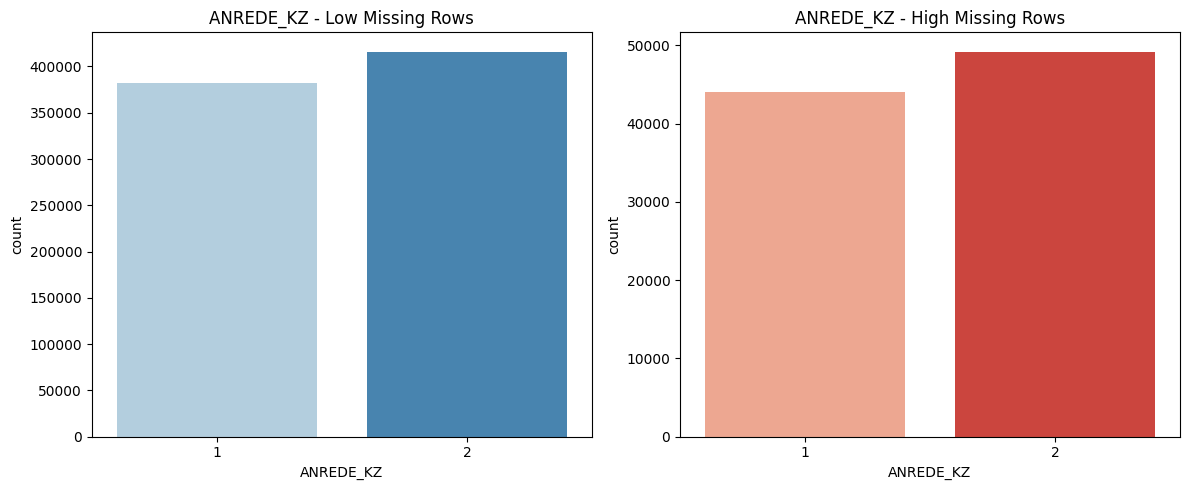

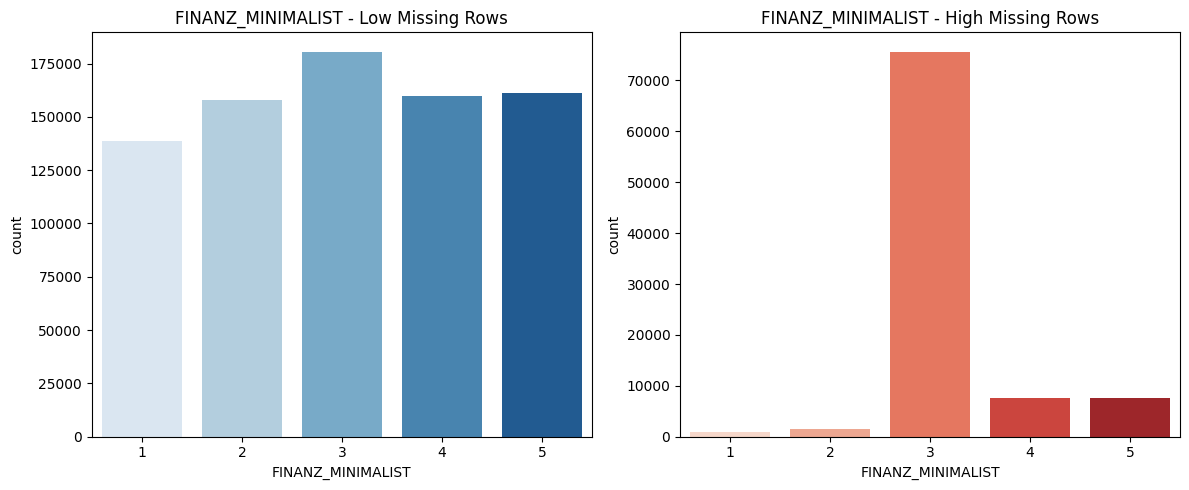

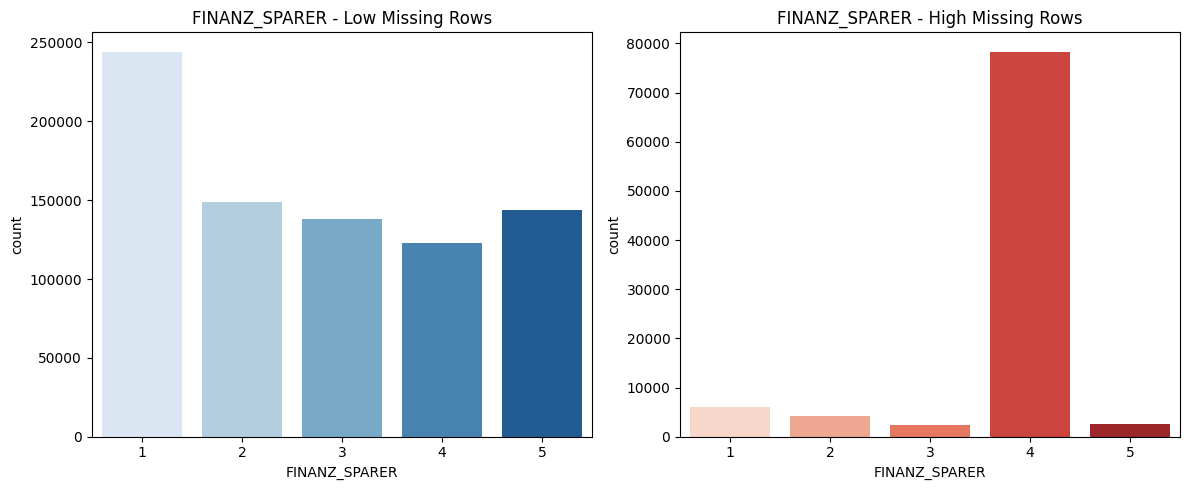

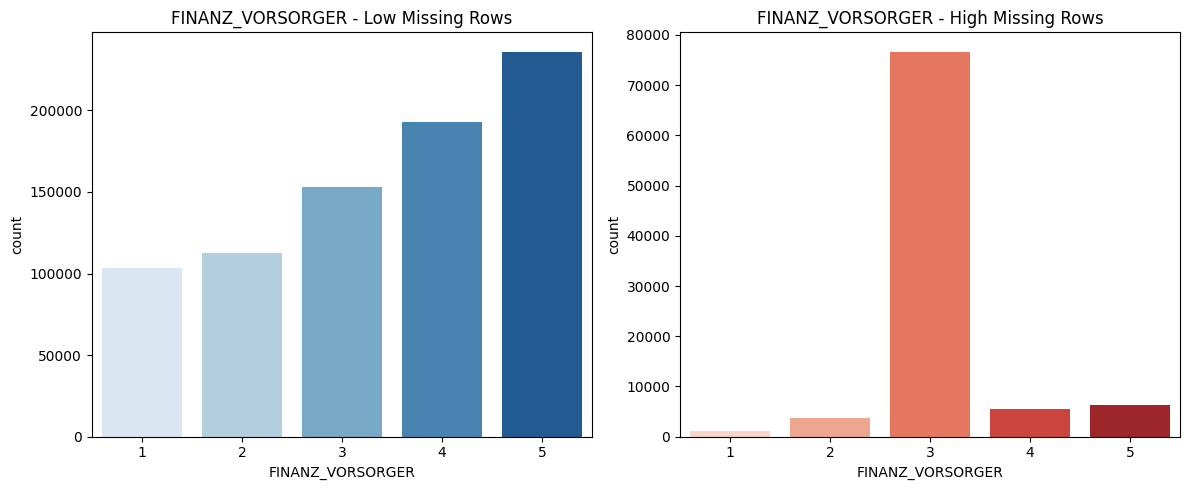

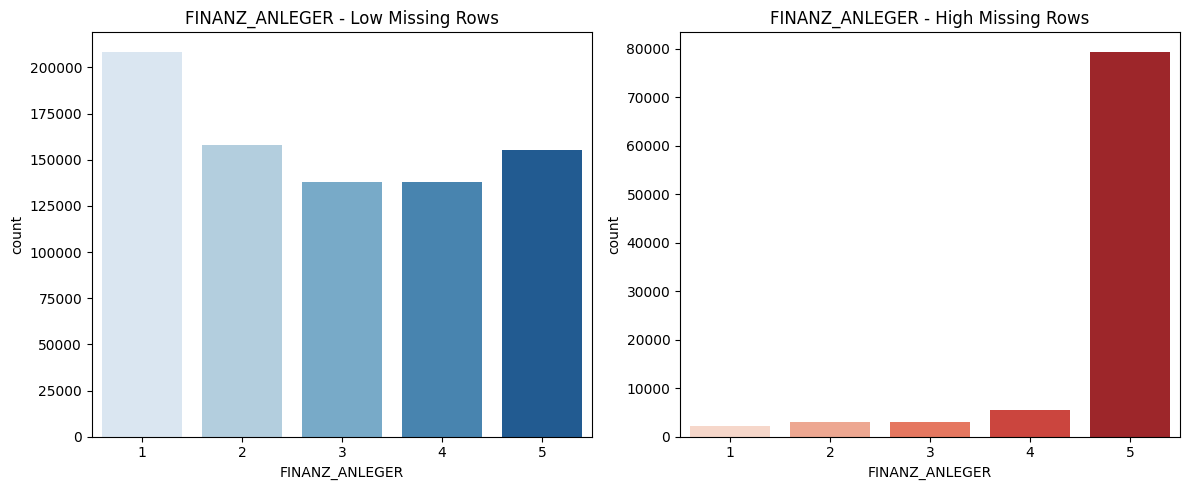

In [8]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_feature_distribution(feature, df1, df2):
    """Plots the distribution of a feature in two datasets (high vs. low missing rows)."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Low-missing rows
    sns.countplot(x=feature, data=df1, ax=axes[0], palette="Blues")
    axes[0].set_title(f"{feature} - Low Missing Rows")
    
    # High-missing rows
    sns.countplot(x=feature, data=df2, ax=axes[1], palette="Reds")
    axes[1].set_title(f"{feature} - High Missing Rows")

    plt.tight_layout()
    plt.show()

# Compare distributions for the selected features
for feature in selected_columns:
    compare_feature_distribution(feature, low_missing_rows, high_missing_rows)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [9]:
# How many features are there of each data type?
# Check the data types of each column
print(azdias_cleaned.dtypes)



ALTERSKATEGORIE_GROB     float64
ANREDE_KZ                  int64
CJT_GESAMTTYP            float64
FINANZ_MINIMALIST          int64
FINANZ_SPARER              int64
FINANZ_VORSORGER           int64
FINANZ_ANLEGER             int64
FINANZ_UNAUFFAELLIGER      int64
FINANZ_HAUSBAUER           int64
FINANZTYP                  int64
GFK_URLAUBERTYP          float64
GREEN_AVANTGARDE           int64
HEALTH_TYP               float64
LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
LP_FAMILIE_FEIN          float64
LP_FAMILIE_GROB          float64
LP_STATUS_FEIN           float64
LP_STATUS_GROB           float64
NATIONALITAET_KZ         float64
PRAEGENDE_JUGENDJAHRE    float64
RETOURTYP_BK_S           float64
SEMIO_SOZ                  int64
SEMIO_FAM                  int64
SEMIO_REL                  int64
SEMIO_MAT                  int64
SEMIO_VERT                 int64
SEMIO_LUST                 int64
SEMIO_ERL                  int64
SEMIO_KULT                 int64
SEMIO_RAT 

In [13]:
# Count how many features there are for each data type
type_counts = feature_summary['type'].value_counts()
print(type_counts)

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [8]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# List all categorical columns
categorical_columns = azdias_cleaned.select_dtypes(include='object').columns

# Assess unique values in each categorical column
for col in categorical_columns:
    print(f"Column: {col}")
    print(azdias_cleaned[col].value_counts())
    print("\n")


Column: OST_WEST_KZ
OST_WEST_KZ
W    629528
O    168545
Name: count, dtype: int64


Column: CAMEO_DEUG_2015
CAMEO_DEUG_2015
8    134441
9    108177
6    105874
4    103912
3     86779
2     83231
7     77933
5     55310
1     36212
X       373
Name: count, dtype: int64


Column: CAMEO_DEU_2015
CAMEO_DEU_2015
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: count, dtype: int64


Column: CAMEO_INTL_2015
CAMEO_INTL_2015
51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25  

In [9]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Re-encode OST_WEST_KZ: Convert 'W' to 0 and 'O' to 1
azdias_cleaned['OST_WEST_KZ'] = azdias_cleaned['OST_WEST_KZ'].map({'W': 0, 'O': 1})

# Convert 'X' and 'XX' to NaN in categorical variables
azdias_cleaned['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
azdias_cleaned['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)
azdias_cleaned['CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)

# Convert categorical variables to numeric (if they represent ordinal categories)
azdias_cleaned['CAMEO_DEUG_2015'] = pd.to_numeric(azdias_cleaned['CAMEO_DEUG_2015'])
azdias_cleaned['CAMEO_INTL_2015'] = pd.to_numeric(azdias_cleaned['CAMEO_INTL_2015'])

# One-Hot Encode CAMEO_DEU_2015 (since it has letter-number combinations)
azdias_cleaned = pd.get_dummies(azdias_cleaned, columns=['CAMEO_DEU_2015'], drop_first=True)


<ipython-input-9-91af2bc25f4c>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  azdias_cleaned['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
<ipython-input-9-91af2bc25f4c>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

#### Discussion 1.2.1: Re-Encode Categorical Features

We identified four categorical features: OST_WEST_KZ, CAMEO_DEUG_2015, CAMEO_DEU_2015, and CAMEO_INTL_2015.

OST_WEST_KZ (binary) was encoded as 0 (O) and 1 (W).
CAMEO_DEUG_2015, CAMEO_DEU_2015, and CAMEO_INTL_2015 (multi-level) were dropped due to high cardinality and complexity in encoding.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [10]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

mainstream_values = {1, 3, 5, 8, 10, 12, 14}

# 1) Create movement variable (binary)
azdias_cleaned["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = azdias_cleaned["PRAEGENDE_JUGENDJAHRE"].isin(mainstream_values).astype(int)

# Define mapping for decade conversion
decade_mapping = {
    1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3,
    8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6
}

# 2) Create decade variable (interval-type)
azdias_cleaned["PRAEGENDE_JUGENDJAHRE_DECADE"] = azdias_cleaned["PRAEGENDE_JUGENDJAHRE"].map(decade_mapping)


In [11]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Create decade variable (interval-type)
azdias_cleaned["PRAEGENDE_JUGENDJAHRE_DECADE"] = azdias_cleaned["PRAEGENDE_JUGENDJAHRE"].map(decade_mapping)


# Convert CAMEO_INTL_2015 to string type to avoid issues with NaN values
azdias_cleaned["CAMEO_INTL_2015"] = azdias_cleaned["CAMEO_INTL_2015"].astype(str)

# Extract the first digit as "Wealth"
azdias_cleaned["WEALTH"] = azdias_cleaned["CAMEO_INTL_2015"].apply(lambda x: pd.NA if x in ["nan", "XX"] else int(x[0]))

# Extract the second digit as "Life Stage"
azdias_cleaned["LIFE_STAGE"] = azdias_cleaned["CAMEO_INTL_2015"].apply(lambda x: pd.NA if x in ["nan", "XX"] else int(x[1]))

# Convert back to numeric type (handles NaNs correctly)
azdias_cleaned["WEALTH"] = pd.to_numeric(azdias_cleaned["WEALTH"], errors='coerce')
azdias_cleaned["LIFE_STAGE"] = pd.to_numeric(azdias_cleaned["LIFE_STAGE"], errors='coerce')

#### Discussion 1.2.2: Engineer Mixed-Type Features

The feature PRAEGENDE_JUGENDJAHRE was split into two variables: DECADE (interval) and MOVEMENT (binary). The feature CAMEO_INTL_2015 was split into two ordinal variables: WEALTH and LIFE_STAGE. Both features were re-engineered using dictionaries and mapped into new columns to make them more suitable for analysis, ensuring that they retained their meaningful dimensions.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [12]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Drop the original columns that were used for feature engineering
azdias_cleaned = azdias_cleaned.drop(columns=["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"])

# Verify the remaining columns
print("Columns after cleaning:")
print(azdias_cleaned.columns)

Columns after cleaning:
Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'PRAEGENDE_JUGENDJAHRE_DECADE',
       'WEALTH', 'LIFE_STAGE'],
      dtype='object', length=123)


In [24]:
# Save the cleaned dataframe to a CSV file
azdias_cleaned.to_csv('azdias_cleaned_2.csv', index=False)

In [13]:
# Load the cleaned dataframe from the CSV file
azdias_cleaned_loaded = pd.read_csv('/kaggle/input/work-space/azdias_cleaned_2.csv')

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [5]:
import numpy as np
import pandas as pd

def clean_data(df, feature_summary):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.

    INPUT:
    - df: Demographics DataFrame.
    - feature_summary: DataFrame containing missing value codes for each feature.

    OUTPUT:
    - Trimmed and cleaned demographics DataFrame.
    """
    # Step 1: Create missing_value_dict from feature_summary
    missing_value_dict = {}
    for _, row in feature_summary.iterrows():
        try:
            missing_values = eval(row['missing_or_unknown'])  # Convert string list to actual list
            if isinstance(missing_values, list):
                missing_value_dict[row['attribute']] = missing_values
        except:
            pass  # Skip if conversion fails (e.g., missing or improperly formatted values)

    # Step 2: Replace missing value codes with NaN
    for col, missing_values in missing_value_dict.items():
        if col in df.columns:
            df[col] = df[col].replace(missing_values, np.nan)
    
    # Step 3: Identify and drop columns with high missing values (e.g., above 30%)
    threshold = 30
    missing_values = df.isnull().mean() * 100
    high_missing_cols = missing_values[missing_values > threshold].index.tolist()
    df.drop(columns=high_missing_cols, inplace=True)
    
    # Step 4: Re-encode categorical variables
    # Re-encode OST_WEST_KZ: Convert 'W' to 0 and 'O' to 1
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'W': 0, 'O': 1})
    
    # Convert 'X' and 'XX' to NaN in categorical variables
    df['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
    df['CAMEO_DEU_2015'].replace('XX', np.nan, inplace=True)
    df['CAMEO_INTL_2015'].replace('XX', np.nan, inplace=True)
    
    # Convert categorical variables to numeric (if they represent ordinal categories)
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'])
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])
    
    # One-Hot Encode CAMEO_DEU_2015 (since it has letter-number combinations)
    df = pd.get_dummies(df, columns=['CAMEO_DEU_2015'], drop_first=True)
    
    # Step 5: Engineer new features
    # Engineer features from "PRAEGENDE_JUGENDJAHRE"
    mainstream_values = {1, 3, 5, 8, 10, 12, 14}
    df["PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = df["PRAEGENDE_JUGENDJAHRE"].isin(mainstream_values).astype(int)
    
    decade_mapping = {
        1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3,
        8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6
    }
    df["PRAEGENDE_JUGENDJAHRE_DECADE"] = df["PRAEGENDE_JUGENDJAHRE"].map(decade_mapping)
    
    # Engineer features from "CAMEO_INTL_2015"
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].astype(str)
    df["WEALTH"] = df["CAMEO_INTL_2015"].apply(lambda x: pd.NA if x in ["nan", "XX"] else int(x[0]))
    df["LIFE_STAGE"] = df["CAMEO_INTL_2015"].apply(lambda x: pd.NA if x in ["nan", "XX"] else int(x[1]))
    df["WEALTH"] = pd.to_numeric(df["WEALTH"], errors='coerce')
    df["LIFE_STAGE"] = pd.to_numeric(df["LIFE_STAGE"], errors='coerce')
    
    # Step 6: Drop original columns used for feature engineering
    df.drop(columns=["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"], inplace=True)
    
    # Return the cleaned dataframe
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [ ]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



In [14]:
from sklearn.impute import SimpleImputer

# Create an imputer object (e.g., using mean for numerical columns)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the dataframe
azdias_cleaned_imputed = pd.DataFrame(imputer.fit_transform(azdias_cleaned), columns=azdias_cleaned.columns)

# Verify the result
print("Missing values after imputation:")
print(azdias_cleaned_imputed.isnull().sum())

Missing values after imputation:
ALTERSKATEGORIE_GROB              0
ANREDE_KZ                         0
CJT_GESAMTTYP                     0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_VORSORGER                  0
FINANZ_ANLEGER                    0
FINANZ_UNAUFFAELLIGER             0
FINANZ_HAUSBAUER                  0
FINANZTYP                         0
GFK_URLAUBERTYP                   0
GREEN_AVANTGARDE                  0
HEALTH_TYP                        0
LP_LEBENSPHASE_FEIN               0
LP_LEBENSPHASE_GROB               0
LP_FAMILIE_FEIN                   0
LP_FAMILIE_GROB                   0
LP_STATUS_FEIN                    0
LP_STATUS_GROB                    0
NATIONALITAET_KZ                  0
RETOURTYP_BK_S                    0
SEMIO_SOZ                         0
SEMIO_FAM                         0
SEMIO_REL                         0
SEMIO_MAT                         0
SEMIO_VERT                        0
SEMIO_LUST                     

In [16]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the imputed data and transform the data
azdias_scaled = scaler.fit_transform(azdias_cleaned_imputed)

# Convert the scaled data back to a DataFrame (optional but recommended for readability)
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_cleaned_imputed.columns)

# Verify the scaled data
print("Scaled General Population Data:")
azdias_scaled.head()

Scaled General Population Data:


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,WEALTH,LIFE_STAGE
0,-0.750972,-1.045218,-1.026509,-0.056416,0.804890,-0.303378,1.285741,1.429871,-0.055511,0.105346,0.753588,-0.494701,0.000000,-1.153150e-01,-0.269485,-0.510535,-0.234979,-1.109834,-0.974346,0.000000,1.117759,-0.999639,0.901553,1.374629,0.537487,-1.455284,0.316841,-0.819565,-0.538400,0.056863,1.221756,0.742018,0.839442,0.420264,-0.387544,0.000000,0.000000,-4.748069e-16,-0.267936,-2.005530e-16,1.315086e-17,-1.373303,0.000000,-4.821477e-16,0.000000,0.000000,0.000000,-2.991342e-16,7.209590e-14,0.000000,0.000000,0.000000,1.715036e-16,1.933734e-16,0.000000,0.000000,3.622076e-16,0.000000,0.000000,0.000000,-5.083367e-16,4.996863e-16,0.000000,-1.119494,0.000000,3.561469e-16,0.000000,0.000000,2.413592e-16,1.637641e-16,0.000000,0.000000,0.000000,-4.709754e-16,4.085377e-16,0.000000,-0.067741,-0.069767,-0.116377,-0.075602,-0.122843,-0.132979,-0.149258,-0.202404,-0.109414,-0.089994,-0.201486,-0.200089,-0.196569,-0.101269,-0.238113,-0.098536,-0.0775,-0.117878,-0.108417,-0.106176,-0.130586,-0.063516,-0.069491,-0.08775,-0.26059,-0.130039,-0.082831,-0.135667,-0.078019,-0.200368,-0.16814,-0.10137,-0.077588,-0.072289,-0.250034,-0.197426,-0.189813,-0.141838,-0.1536,-0.179023,-0.16984,-0.182061,-0.084907,-1.464537,0.000000,-3.216984e-16,3.173052e-16
1,-1.742724,0.956738,0.859488,-1.570358,1.487601,-1.059731,1.285741,0.757254,1.422415,-1.403804,0.753588,-0.494701,1.146266,4.040595e-01,0.294772,0.286205,0.380189,-0.817091,-0.974346,-0.379294,-1.711347,0.541539,-0.142352,-0.119863,-0.539206,-1.455284,-1.166231,-1.372799,-0.538400,1.322441,-0.416882,1.298900,-0.240231,1.550121,1.369271,1.466005,11.326853,1.045294e+00,1.210585,2.460008e-01,-6.309721e-02,1.115418,-0.704046,5.923631e-01,0.179062,-0.132882,2.068920,-1.359610e+00,-4.049161e-01,-0.546792,-0.028640,1.049165,-1.154155e+00,-1.102167e+00,-0.668250,2.876115,-1.760579e+00,0.894118,-0.577568,1.797840,-8.451187e-01,-8.139469e-01,-1.490154,0.198572,-0.883834,1.075452e+00,-0.279538,0.230923,4.397660e-01,4.437471e-01,-0.693596,1.527612,0.597182,-1.767775e-01,-1.349507e-01,0.723463,-0.067741,-0.069767,-0.116377,-0.075602,-0.122843,-0.132979,-0.149258,-0.202404,-0.109414,-0.089994,-0.201486,-0.200089,-0.196569,-

### Discussion 2.1: Apply Feature Scaling

I replaced all missing values with the most frequent value in the column using the Imputer method. Then, I applied feature scaling to all features using the StandardScaler to ensure they have a mean of 0 and a standard deviation of 1, which is important for algorithms that rely on distance-based calculations

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [19]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

## Initialize PCA 
pca = PCA()
# Fit PCA on the scaled data
pca.fit(azdias_scaled)

# Transform the data (optional at this stage)
azdias_pca = pca.transform(azdias_scaled)

In [20]:
# Get the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)


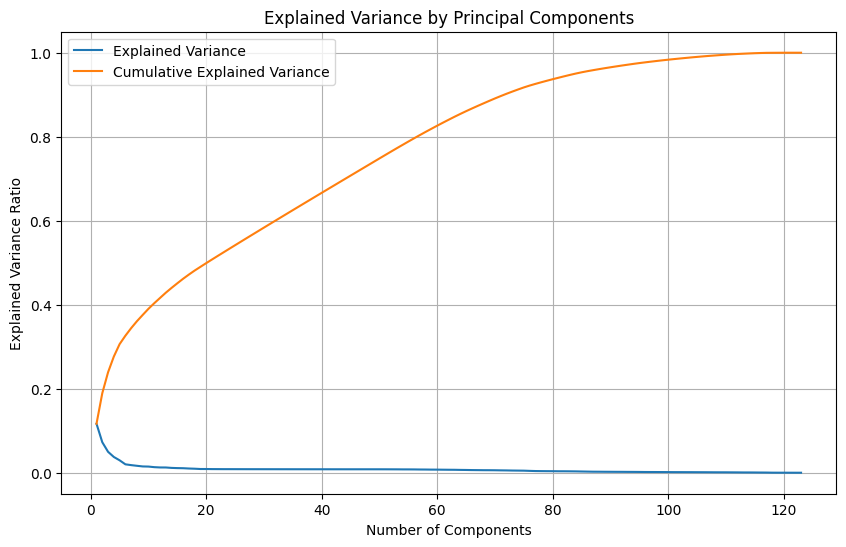

In [21]:
# Investigate the variance accounted for by each principal component.

# Plot the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, label='Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.grid()
plt.show()

In [22]:
# Set the desired explained variance threshold (e.g., 90%)
threshold = 0.90

# Compute the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that exceed the threshold
n_components = np.argmax(cumulative_explained_variance >= threshold) + 1

print(f"Number of components to retain for {threshold * 100}% variance: {n_components}")

Number of components to retain for 90.0% variance: 72


In [23]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=n_components)

# Fit and transform the scaled data
azdias_pca = pca.fit_transform(azdias_scaled)

# Verify the shape of the transformed data
print("Shape of the transformed data:", azdias_pca.shape)


Shape of the transformed data: (891221, 72)


### Discussion 2.2: Perform Dimensionality Reduction

Principal Component Analysis (PCA) was applied to the scaled data to reduce its dimensionality while preserving as much variance as possible. Based on the selected number of components (72 components), the dataset was transformed into a lower-dimensional space.

This reduction helps improve computational efficiency and eliminates redundant features while retaining the most significant information. The transformed data will now be used for clustering and further analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.



In [24]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def pca_weights(pca, component_index, feature_names):
  
    # Get the weights for the specified principal component
    weights = pca.components_[component_index]

    # Create a DataFrame to map feature names to their weights
    df_weights = pd.DataFrame({
        'Feature': feature_names,
        'Weight': weights
    })

    # Sort the DataFrame by absolute weight (to identify the most influential features)
    df_weights = df_weights.reindex(df_weights['Weight'].abs().sort_values(ascending=False).index)

    return df_weights


In [25]:
# Get the feature names from the original dataset
feature_names = azdias_scaled.columns

# Analyze the first principal component
print("First Principal Component:")
df_weights_pc1 = pca_weights(pca, 0, feature_names)
print(df_weights_pc1.head(10))  # Top 10 features with the highest absolute weights
print(df_weights_pc1.tail(10))  # Bottom 10 features with the lowest absolute weights

First Principal Component:
             Feature    Weight
62        MOBI_REGIO -0.215107
17    LP_STATUS_FEIN -0.206354
18    LP_STATUS_GROB -0.202923
52       KBA05_ANTG1 -0.200883
66        PLZ8_ANTG1 -0.198250
51   CAMEO_DEUG_2015  0.197777
68        PLZ8_ANTG3  0.197720
121           WEALTH  0.195011
56         KBA05_GBZ -0.191730
69        PLZ8_ANTG4  0.191675
               Feature    Weight
20      RETOURTYP_BK_S  0.004274
40           ANZ_TITEL -0.004164
104  CAMEO_DEU_2015_6F  0.003593
109  CAMEO_DEU_2015_7E  0.003487
35         SHOPPER_TYP  0.003150
36             SOHO_KZ -0.002346
101  CAMEO_DEU_2015_6C  0.002257
93   CAMEO_DEU_2015_5A  0.001676
97   CAMEO_DEU_2015_5E -0.001495
102  CAMEO_DEU_2015_6D  0.001388


In [26]:
# Analyze the second principal component
print("\nSecond Principal Component:")
df_weights_pc2 = pca_weights(pca, 1, feature_names)
print(df_weights_pc2.head(10))
print(df_weights_pc2.tail(10))



Second Principal Component:
                          Feature    Weight
0            ALTERSKATEGORIE_GROB  0.271395
4                   FINANZ_SPARER -0.266030
120  PRAEGENDE_JUGENDJAHRE_DECADE -0.265493
23                      SEMIO_REL -0.251868
5                FINANZ_VORSORGER  0.251649
33                  SEMIO_PFLICHT -0.247131
7           FINANZ_UNAUFFAELLIGER -0.241046
34                    SEMIO_TRADV -0.231403
6                  FINANZ_ANLEGER -0.228876
27                      SEMIO_ERL  0.216885
               Feature    Weight
116  CAMEO_DEU_2015_9C  0.003539
71            PLZ8_HHZ  0.003509
17      LP_STATUS_FEIN -0.003255
76   CAMEO_DEU_2015_1B  0.001436
91   CAMEO_DEU_2015_4D  0.001434
36             SOHO_KZ -0.001415
99   CAMEO_DEU_2015_6A -0.000995
83   CAMEO_DEU_2015_2D  0.000852
100  CAMEO_DEU_2015_6B  0.000587
115  CAMEO_DEU_2015_9B  0.000413


In [27]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Analyze the third principal component
print("\nThird Principal Component:")
df_weights_pc3 = pca_weights(pca, 2, feature_names)
print(df_weights_pc3.head(10))
print(df_weights_pc3.tail(10))



Third Principal Component:
       Feature    Weight
1    ANREDE_KZ -0.357409
32  SEMIO_KAEM -0.356710
25  SEMIO_VERT  0.344576
31   SEMIO_DOM -0.328534
30  SEMIO_KRIT -0.302503
28  SEMIO_KULT  0.286011
21   SEMIO_SOZ  0.285206
22   SEMIO_FAM  0.240434
27   SEMIO_ERL -0.189632
29   SEMIO_RAT -0.168712
              Feature    Weight
82  CAMEO_DEU_2015_2C  0.001292
91  CAMEO_DEU_2015_4D  0.001264
92  CAMEO_DEU_2015_4E  0.001103
97  CAMEO_DEU_2015_5E  0.001000
94  CAMEO_DEU_2015_5B  0.000694
89  CAMEO_DEU_2015_4B -0.000693
36            SOHO_KZ  0.000660
76  CAMEO_DEU_2015_1B -0.000569
64           REGIOTYP -0.000467
93  CAMEO_DEU_2015_5A  0.000160


### Discussion 2.3: Interpret Principal Components

The first component shows that MOBI_REGIO, KBA05_ANTG1, and PLZ8_ANTG1 are positively correlated, indicating that higher mobility regions are linked with more family homes and specific car ownership.

The second component indicates that SEMIO_REL, DECADE, and FINANZ_SPARER are linked, showing that wealthier, more financially responsible populations are grouped by generation and social values.

The third component highlights that ANREDE_KZ, SEMIO_KAEM, and SEMIO_DOM are significant, showing that demographic factors like title status and cultural attitudes contribute significantly to variability, particularly among wealthier individuals

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

Fitting K-Means with 2 clusters...
Fitting K-Means with 3 clusters...
Fitting K-Means with 4 clusters...
Fitting K-Means with 5 clusters...
Fitting K-Means with 6 clusters...
Fitting K-Means with 7 clusters...
Fitting K-Means with 8 clusters...
Fitting K-Means with 9 clusters...
Fitting K-Means with 10 clusters...
Fitting K-Means with 11 clusters...
Fitting K-Means with 12 clusters...
Fitting K-Means with 13 clusters...
Fitting K-Means with 14 clusters...
Fitting K-Means with 15 clusters...
Fitting K-Means with 16 clusters...
Fitting K-Means with 17 clusters...
Fitting K-Means with 18 clusters...
Fitting K-Means with 19 clusters...
Fitting K-Means with 20 clusters...


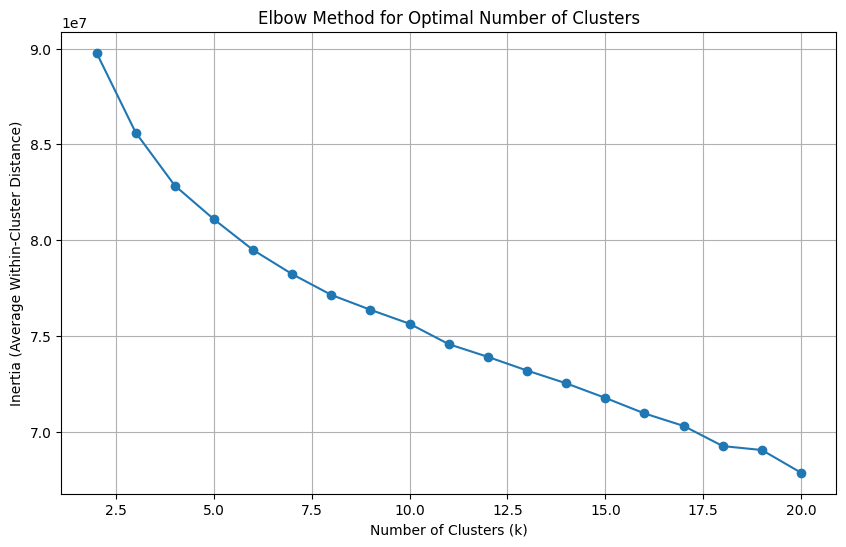

In [28]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
from sklearn.cluster import KMeans

# Define a range of cluster counts to test
cluster_counts = range(2, 21)

# Initialize a list to store the inertia values
inertia_values = []

# Perform K-Means clustering for each cluster count
for k in cluster_counts:
    print(f"Fitting K-Means with {k} clusters...")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # n_init to avoid convergence warnings
    kmeans.fit(azdias_pca)  # Fit on the PCA-transformed data
    inertia_values.append(kmeans.inertia_)  # Store the inertia value

# Plot the inertia values
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, inertia_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Average Within-Cluster Distance)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid()
plt.show()

In [ ]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [29]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

optimal_clusters = 5
# Re-fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(azdias_pca)

# Get the cluster assignments for the general population data
general_population_clusters = kmeans.predict(azdias_pca)

# Verify the cluster assignments
print("Cluster assignments for the general population data:")
print(general_population_clusters[:10])  # Print the first 10 assignments

Cluster assignments for the general population data:
[4 3 4 0 2 4 4 0 0 4]


In [46]:
# Save the cluster assignments to a CSV file
np.savetxt('general_population_clusters.csv', general_population_clusters, delimiter=',')

### Discussion 3.1: Apply Clustering to General Population
In the graph, the SSE decreases steeply from 1 to around 5 clusters, after which the rate of decline slows down and the curve flattens out. This suggests that the optimal number of clusters is around 4 or 5.


 The K-Means clustering algorithm was applied to the general population data using the optimal number of clusters (5 clusters). After fitting the model, each individual in the dataset was assigned to one of these clusters based on their principal component features. 


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [30]:
# Load in the customer demographics data.
customers =pd.read_csv('/kaggle/input/work-space/Udacity_CUSTOMERS_Subset.csv', sep=';') 

In [33]:
# Clean the customer data
customers_cleaned = clean_data(customers, feature_summary)

# Verify the cleaned data
print("Shape of cleaned customer data:", customers_cleaned.shape)
customers_cleaned.head()

<ipython-input-5-78bd384a1ad1>:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CAMEO_DEUG_2015'].replace('X', np.nan, inplace=True)
<ipython-input-5-78bd384a1ad1>:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

Shape of cleaned customer data: (191652, 121)


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,MOBI_REGIO,ONLINE_AFFINITAET,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,WEALTH,LIFE_STAGE
0,4.0,1,5.0,5,1,5,1,2,2,2,4.0,1,1.0,20.0,5.0,2.0,2.0,10.0,5.0,1.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3.0,0.0,1.0,3,2.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,0.0,7.0,1.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,4.0,3.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,2.0,1.0,3.0
1,4.0,1,NaN,5,1,5,1,3,2,2,NaN,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3.0,0.0,1.0,3,3.0,0.0,NaN,NaN,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,NaN,NaN,NaN
2,4.0,2,2.0,5,1,5,1,4,4,2,3.0,1,2.0,13.0,3.0,1.0,1.0,10.0,5.0,1.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1.0,0.0,2.0,3,1.0,0.0,1.0,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,0.0,2.0,5.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,1.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,2.0,3.0,4.0
3,4.0,1,2.0,5,1,5,2,1,2,6,10.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,0.0,1.0,1,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,2.0,1992.0,0.0,7.0,4.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,4.0,2.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1,1.0,2.0,4.0
4,3.0,1,6.0,3,1,4,4,5,2,2,2.0,0,3.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,5.0,4,5,4,6

In [34]:
# Get the columns in the cleaned general population data
general_population_columns = azdias_cleaned.columns

# Add missing columns to the cleaned customer data and fill with NaN
for col in general_population_columns:
    if col not in customers_cleaned.columns:
        customers_cleaned[col] = np.nan

# Ensure the columns are in the same order
customers_cleaned = customers_cleaned[general_population_columns]

In [35]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Impute missing values using the fitted imputer
customers_imputed = pd.DataFrame(imputer.transform(customers_cleaned), columns=customers_cleaned.columns)

# Verify the imputed data
print("Missing values after imputation:")
print(customers_imputed.isnull().sum())

Missing values after imputation:
ALTERSKATEGORIE_GROB              0
ANREDE_KZ                         0
CJT_GESAMTTYP                     0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_VORSORGER                  0
FINANZ_ANLEGER                    0
FINANZ_UNAUFFAELLIGER             0
FINANZ_HAUSBAUER                  0
FINANZTYP                         0
GFK_URLAUBERTYP                   0
GREEN_AVANTGARDE                  0
HEALTH_TYP                        0
LP_LEBENSPHASE_FEIN               0
LP_LEBENSPHASE_GROB               0
LP_FAMILIE_FEIN                   0
LP_FAMILIE_GROB                   0
LP_STATUS_FEIN                    0
LP_STATUS_GROB                    0
NATIONALITAET_KZ                  0
RETOURTYP_BK_S                    0
SEMIO_SOZ                         0
SEMIO_FAM                         0
SEMIO_REL                         0
SEMIO_MAT                         0
SEMIO_VERT                        0
SEMIO_LUST                     

In [36]:
# Step 5: Scale the customer data using the fitted scaler
customers_scaled = pd.DataFrame(scaler.transform(customers_imputed), columns=customers_imputed.columns)

In [37]:
# Step 6: Transform the customer data using the fitted PCA
customers_pca = pca.transform(customers_scaled)

In [38]:
# Step 7: Predict cluster assignments for the customer data
customer_clusters = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [44]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population

# Count the number of data points in each cluster for the general population
general_population_cluster_counts = np.bincount(general_population_clusters)

# Count the number of data points in each cluster for the customer data
customer_cluster_counts = np.bincount(customer_clusters)

# Create a DataFrame to compare the cluster distributions
cluster_comparison = pd.DataFrame({
    'General Population': general_population_cluster_counts,
    'Customers': customer_cluster_counts
})

print(cluster_comparison)

   General Population  Customers
0              181794      51012
1              192972      28935
2              157359      59171
3              145719       2759
4              213377      49775


In [43]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Identify overrepresented clusters

# Calculate the percentage difference between the two distributions
cluster_comparison['Percentage Difference'] = (
    (cluster_comparison['Customers'] - cluster_comparison['General Population']) / 
    cluster_comparison['General Population']
) * 100

# Display the comparison
print(cluster_comparison)


   General Population  Customers  Percentage Difference
0              181794      51012             -71.939668
1              192972      28935             -85.005597
2              157359      59171             -62.397448
3              145719       2759             -98.106630
4              213377      49775             -76.672744


In [50]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_comparison['Percentage Difference'] = (
    (cluster_comparison['Customers'] - cluster_comparison['General Population']) /
    cluster_comparison['General Population'].replace(0, np.nan)  # Prevent division by zero
) * 100


underrepresented_clusters = cluster_comparison[cluster_comparison['Percentage Difference'] < 0]\
    .sort_values(by='Percentage Difference', ascending=True)

print(underrepresented_clusters)


   General Population  Customers  Percentage Difference
3              145719       2759             -98.106630
1              192972      28935             -85.005597
4              213377      49775             -76.672744
0              181794      51012             -71.939668
2              157359      59171             -62.397448


### Discussion 3.3: Compare Customer Data to Demographics Data

The analysis of the customer data compared to the general population reveals significant differences in representation across clusters.

Overrepresented Clusters:

Some clusters have a higher percentage of customers compared to the general population.
These groups likely represent the target audience of the business.
Underrepresented Clusters:

Certain clusters show a much lower percentage of customers compared to the general population.
These groups may be less engaged or not part of the business's primary demographic.
Understanding these trends helps refine marketing strategies and identify potential growth opportunities in underrepresented segments

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.